In [ ]:
!pip install pandas geopandas folium


In [ ]:
#import xarray as xr
#import rioxarray as rxr
import numpy as np
import pandas as pd

# Read the CSV files into DataFrames
df = pd.read_csv('/content/drive/MyDrive/ATM_MOD/GHENT/GHENT_2016_2017.csv')
df1 = pd.read_csv('/content/drive/MyDrive/ATM_MOD/GHENT/SNZ_temp_GF_round_40d.csv')
df2 = pd.read_csv('/content/drive/MyDrive/ATM_MOD/GHENT/SLP_temp_GF_round_40d.csv')
df3 = pd.read_csv('/content/drive/MyDrive/ATM_MOD/GHENT/HAP_temp_GF_round_40d.csv')
df4 = pd.read_csv('/content/drive/MyDrive/ATM_MOD/GHENT/GRM_temp_GF_round_40d.csv')
df5 = pd.read_csv('/content/drive/MyDrive/ATM_MOD/GHENT/DOC_temp_GF_round_40d.csv')
df6 = pd.read_csv('/content/drive/MyDrive/ATM_MOD/GHENT/BAS_temp_GF_round_40d.csv')
df1['Station'] = 'SNZ'
df2['Station'] = 'SLP'
df3['Station'] = 'HAP'
df4['Station'] = 'GRM'
df5['Station'] = 'DOC'
df6['Station'] = 'BAS'
# Concatenate df1 to df6 vertically
concatenated_df = pd.concat([df1, df2, df3, df4, df5, df6])
df.rename(columns={'x': 'x_urb', 'y': 'y_urb'}, inplace=True)


# Update y coordinates in df to match the format of concatenated_df
y_mapping = {
    51.108624: 51.109,
    51.08451: 51.084,
    51.052357: 51.052,
    50.98002: 50.98043,
    51.05121: 51.0512,
    51.035133: 51.0357
}
df['y'] = df['y_urb'].map(y_mapping)

x_mapping = {
    3.749461: 3.749,
    3.702383: 3.702875,
    3.732237: 3.732,
    3.8160589: 3.815744,
    3.7276442: 3.727799,
    3.721903: 3.72247
}
df['x'] = df['x_urb'].map(x_mapping)



# Assuming concatenate_df is your DataFrame
df['time'] = pd.to_datetime(df['time'])
concatenated_df['time'] = pd.to_datetime(concatenated_df['DateTime'])

# Now you can concatenate horizontally with df based on x, y, and time
test = pd.merge(df, concatenated_df, on=['x', 'y', 'time'], how='inner')

In [ ]:


# Count NaN values per column before dropping
test_nan_before_drop = test.isnull().sum()

# Drop rows with NaN values in 'T_TARGET' column
test = test.dropna(subset=['T_TARGET'])

test = test.rename(columns={'T_2M': 'T2M_NC'})
test = test.rename(columns={'T_2M_COR': 'T2M'})

test['T2M_difference'] = test['T_TARGET'] - test['T2M']
test['T2M'] = test['T2M'] - 273.15
test['T2M_NC'] = test['T2M_NC'] - 273.15

test = test.dropna(subset=['T2M_difference'])

# Count NaN values per column after dropping 'T_TARGET'
test_nan_after_drop = test.isnull().sum()

# Fill NaN values with 0 in 'CBH' column

# Count NaN values per column after filling with 0
test_nan_after_fill = test.isnull().sum()

# Fill NaN values with the median value of the specific 'City'
for column in test.columns:
    if test[column].isnull().any():
        test[column] = test.groupby('city')[column].transform(lambda x: x.fillna(x.median()))



# Count NaN values per column after filling with median
test_nan_after_median_fill = test.isnull().sum()

# Calculate number of NaN values filled and dropped per column
test_nan_filled = test_nan_before_drop - test_nan_after_fill

test_nan_dropped = test_nan_after_drop - test_nan_after_median_fill

# Writing results to a file
with open('run_time.txt', 'a') as f:
    f.write("NaN values filled per column before dropping 'T_TARGET':\n")
    f.write("Test Data:\n")
    f.write(test_nan_filled.to_string() + "\n")
    f.write("\n")
    f.write("NaN values dropped per column after dropping 'T_TARGET':\n")
    f.write("Test Data:\n")
    f.write(test_nan_dropped.to_string() + "\n")


y_test = test['T2M_difference']
X_test = test[['LC_CORINE', 'IMPERV', 'HEIGHT', 'COAST', 'ELEV', 'POP', 'RH', 'SP', 'PRECIP','T2M', 'WS', 'TCC', 'CAPE', 'BLH', 'SSR', 'SOLAR_ELEV', 'DECL']]
import matplotlib.pyplot as plt
import pandas as pd
import joblib

# Define temporal and spatial features
temporal_feat = [ 'RH', 'SP', 'PRECIP', 'T2M', 'WS','TCC',  'CAPE', 'BLH', 'SSR', 'SOLAR_ELEV', 'DECL']
spatial_feat = ['LC_CORINE', 'IMPERV', 'HEIGHT',  'COAST', 'ELEV', 'POP']

# Load the model
model = joblib.load("/content/drive/MyDrive/ATM_MOD/GHENT/model_FINAL.joblib")


# Make predictions
y_pred = model.predict(X_test)+X_test['T2M']
y_test=test['T2M_difference'] +X_test['T2M']

test['y_pred']=y_pred
test['y_test']=y_test
test['ERA5']=X_test['T2M']

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


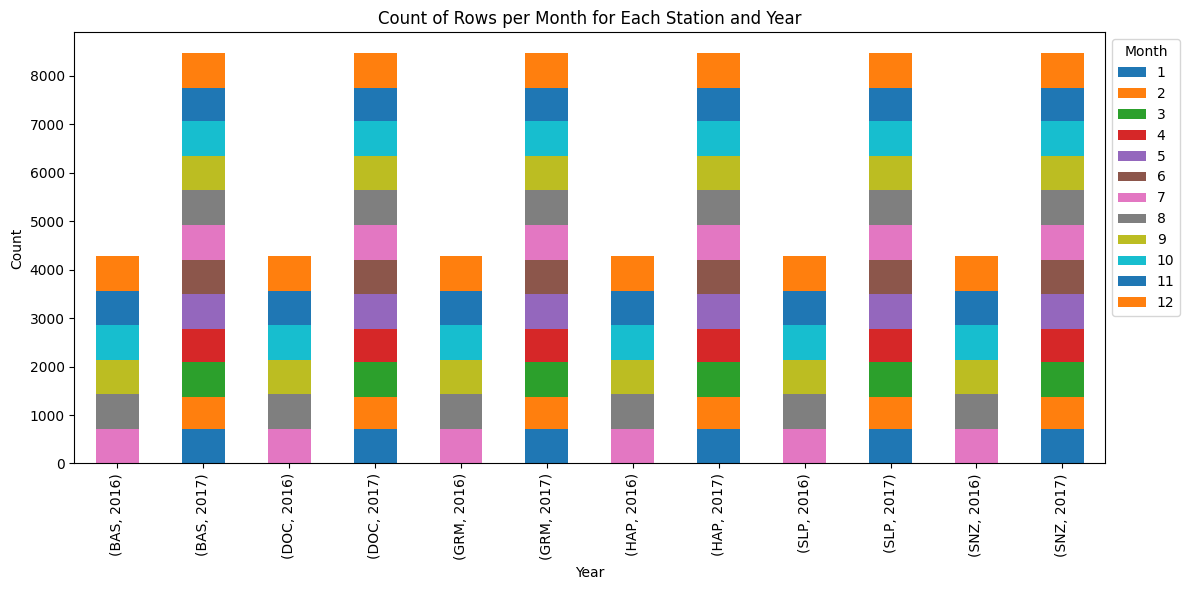

In [ ]:
test['Station'].unique()
#how many obs per month per year
import pandas as pd
import matplotlib.pyplot as plt
df=test
# Assuming 'test' is your DataFrame
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Extract year and month from the DateTime column
df['Year'] = df['DateTime'].dt.year
df['Month'] = df['DateTime'].dt.month

# Group by station, year, and month and count rows in each group
rows_per_station_per_year_per_month = df.groupby(['Station', 'Year', 'Month']).size()

# Unstack the multi-index to make it easier to plot
rows_per_station_per_year_per_month = rows_per_station_per_year_per_month.unstack(level='Month')

# Plotting
rows_per_station_per_year_per_month.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count of Rows per Month for Each Station and Year')
plt.legend(title='Month', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate bias
bias_y_pred_vs_y_test = np.mean(test['y_pred'] - test['y_test'])
bias_y_pred_vs_Temperature = np.mean(test['y_pred'] - test['Temperature'])
bias_y_test_vs_Temperature = np.mean(test['y_test'] - test['Temperature'])
bias_ERA5_vs_Temperature = np.mean(test['ERA5'] - test['Temperature'])

# Calculate RMSE
rmse_y_pred_vs_y_test = np.sqrt(mean_squared_error(test['y_test'], test['y_pred']))
rmse_y_pred_vs_Temperature = np.sqrt(mean_squared_error(test['Temperature'], test['y_pred']))
rmse_y_test_vs_Temperature = np.sqrt(mean_squared_error(test['Temperature'], test['y_test']))
rmse_ERA5_vs_Temperature = np.sqrt(mean_squared_error(test['Temperature'], test['ERA5']))


# Calculate MAE
mae_y_pred_vs_y_test = mean_absolute_error(test['y_test'], test['y_pred'])
mae_y_pred_vs_Temperature = mean_absolute_error(test['Temperature'], test['y_pred'])
mae_y_test_vs_Temperature = mean_absolute_error(test['Temperature'], test['y_test'])
mae_ERA5_vs_Temperature = mean_absolute_error(test['Temperature'], test['ERA5'])

print("Bias (EURO-RFUE vs UrbClim):", bias_y_pred_vs_y_test)
print("RMSE (EURO-RFUE vs UrbClim):", rmse_y_pred_vs_y_test)
print("MAE (EURO-RFUE vs UrbClim):", mae_y_pred_vs_y_test)

print("\nBias (EURO-RFUE vs Observation):", bias_y_pred_vs_Temperature)
print("RMSE (EURO-RFUE vs Observation):", rmse_y_pred_vs_Temperature)
print("MAE (EURO-RFUE vs Observation):", mae_y_pred_vs_Temperature)

print("\nBias (UrbClim vs Observation):", bias_y_test_vs_Temperature)
print("RMSE (UrbClim vs Observation):", rmse_y_test_vs_Temperature)
print("MAE (UrbClim vs Observation):", mae_y_test_vs_Temperature)

print("\nBias (ERA5 vs Observation):", bias_ERA5_vs_Temperature)
print("RMSE (ERA5 vs Observation):", rmse_ERA5_vs_Temperature)
print("MAE (ERA5 vs Observation):", mae_ERA5_vs_Temperature)




Bias (EURO-RFUE vs UrbClim): 0.08713807950372777
RMSE (EURO-RFUE vs UrbClim): 0.8056923499465207
MAE (EURO-RFUE vs UrbClim): 0.613619451535036

Bias (EURO-RFUE vs Observation): 0.11343371365838534
RMSE (EURO-RFUE vs Observation): 0.9909018847878676
MAE (EURO-RFUE vs Observation): 0.7349975685559457

Bias (UrbClim vs Observation): 0.026295634154657598
RMSE (UrbClim vs Observation): 1.173413164427662
MAE (UrbClim vs Observation): 0.8798678019721693

Bias (ERA5 vs Observation): -0.5874036264124066
RMSE (ERA5 vs Observation): 1.140800961906465
MAE (ERA5 vs Observation): 0.8545463908505844


In [ ]:
test_night=test[test['SOLAR_ELEV']<0]
# Calculate bias
bias_y_pred_vs_y_test = np.mean(test_night['y_pred'] - test_night['y_test'])
bias_y_pred_vs_Temperature = np.mean(test_night['y_pred'] - test_night['Temperature'])
bias_y_test_vs_Temperature = np.mean(test_night['y_test'] - test_night['Temperature'])
bias_ERA5_vs_Temperature = np.mean(test_night['ERA5'] - test_night['Temperature'])

# Calculate RMSE
rmse_y_pred_vs_y_test = np.sqrt(mean_squared_error(test_night['y_test'], test_night['y_pred']))
rmse_y_pred_vs_Temperature = np.sqrt(mean_squared_error(test_night['Temperature'], test_night['y_pred']))
rmse_y_test_vs_Temperature = np.sqrt(mean_squared_error(test_night['Temperature'], test_night['y_test']))
rmse_ERA5_vs_Temperature = np.sqrt(mean_squared_error(test_night['Temperature'], test_night['ERA5']))

# Calculate MAE
mae_y_pred_vs_y_test = mean_absolute_error(test_night['y_test'], test_night['y_pred'])
mae_y_pred_vs_Temperature = mean_absolute_error(test_night['Temperature'], test_night['y_pred'])
mae_y_test_vs_Temperature = mean_absolute_error(test_night['Temperature'], test_night['y_test'])
mae_ERA5_vs_Temperature = mean_absolute_error(test_night['Temperature'], test_night['ERA5'])

print("Bias (EURO-RFUE vs UrbClim):", bias_y_pred_vs_y_test)
print("RMSE (EURO-RFUE vs UrbClim):", rmse_y_pred_vs_y_test)
print("MAE (EURO-RFUE vs UrbClim):", mae_y_pred_vs_y_test)

print("\nBias (EURO-RFUE vs Observation):", bias_y_pred_vs_Temperature)
print("RMSE (EURO-RFUE vs Observation):", rmse_y_pred_vs_Temperature)
print("MAE (EURO-RFUE vs Observation):", mae_y_pred_vs_Temperature)

print("\nBias (UrbClim vs Observation):", bias_y_test_vs_Temperature)
print("RMSE (UrbClim vs Observation):", rmse_y_test_vs_Temperature)
print("MAE (UrbClim vs Observation):", mae_y_test_vs_Temperature)

print("\nBias (ERA5 vs Observation):", bias_ERA5_vs_Temperature)
print("RMSE (ERA5 vs Observation):", rmse_ERA5_vs_Temperature)
print("MAE (ERA5 vs Observation):", mae_ERA5_vs_Temperature)


Bias (EURO-RFUE vs UrbClim): 0.15324731265299324
RMSE (EURO-RFUE vs UrbClim): 0.8605727316325271
MAE (EURO-RFUE vs UrbClim): 0.6609749831022864

Bias (EURO-RFUE vs Observation): 0.3291487396665695
RMSE (EURO-RFUE vs Observation): 1.0736213878264178
MAE (EURO-RFUE vs Observation): 0.795951613583247

Bias (UrbClim vs Observation): 0.17590142701357628
RMSE (UrbClim vs Observation): 1.1932729826575648
MAE (UrbClim vs Observation): 0.8905757854286777

Bias (ERA5 vs Observation): -0.7314839359713122
RMSE (ERA5 vs Observation): 1.2971791296275583
MAE (ERA5 vs Observation): 0.9803807054577421


In [ ]:
test_day=test[test['SOLAR_ELEV']>0]
# Calculate bias
bias_y_pred_vs_y_test = np.mean(test_day['y_pred'] - test_day['y_test'])
bias_y_pred_vs_Temperature = np.mean(test_day['y_pred'] - test_day['Temperature'])
bias_y_test_vs_Temperature = np.mean(test_day['y_test'] - test_day['Temperature'])
bias_ERA5_vs_Temperature = np.mean(test_day['ERA5'] - test_day['Temperature'])

# Calculate RMSE
rmse_y_pred_vs_y_test = np.sqrt(mean_squared_error(test_day['y_test'], test_day['y_pred']))
rmse_y_pred_vs_Temperature = np.sqrt(mean_squared_error(test_day['Temperature'], test_day['y_pred']))
rmse_y_test_vs_Temperature = np.sqrt(mean_squared_error(test_day['Temperature'], test_day['y_test']))
rmse_ERA5_vs_Temperature = np.sqrt(mean_squared_error(test_day['Temperature'], test_day['ERA5']))

# Calculate MAE
mae_y_pred_vs_y_test = mean_absolute_error(test_day['y_test'], test_day['y_pred'])
mae_y_pred_vs_Temperature = mean_absolute_error(test_day['Temperature'], test_day['y_pred'])
mae_y_test_vs_Temperature = mean_absolute_error(test_day['Temperature'], test_day['y_test'])
mae_ERA5_vs_Temperature = mean_absolute_error(test_day['Temperature'], test_day['ERA5'])

print("Bias (EURO-RFUE vs UrbClim):", bias_y_pred_vs_y_test)
print("RMSE (EURO-RFUE vs UrbClim):", rmse_y_pred_vs_y_test)
print("MAE (EURO-RFUE vs UrbClim):", mae_y_pred_vs_y_test)

print("\nBias (EURO-RFUE vs Observation):", bias_y_pred_vs_Temperature)
print("RMSE (EURO-RFUE vs Observation):", rmse_y_pred_vs_Temperature)
print("MAE (EURO-RFUE vs Observation):", mae_y_pred_vs_Temperature)

print("\nBias (UrbClim vs Observation):", bias_y_test_vs_Temperature)
print("RMSE (UrbClim vs Observation):", rmse_y_test_vs_Temperature)
print("MAE (UrbClim vs Observation):", mae_y_test_vs_Temperature)

print("\nBias (ERA5 vs Observation):", bias_ERA5_vs_Temperature)
print("RMSE (ERA5 vs Observation):", rmse_ERA5_vs_Temperature)
print("MAE (ERA5 vs Observation):", mae_ERA5_vs_Temperature)


Bias (EURO-RFUE vs UrbClim): 0.020046353403311103
RMSE (EURO-RFUE vs UrbClim): 0.7458792601157135
MAE (EURO-RFUE vs UrbClim): 0.5655601381547702

Bias (EURO-RFUE vs Observation): -0.10548719574027617
RMSE (EURO-RFUE vs Observation): 0.8992064202686693
MAE (EURO-RFUE vs Observation): 0.6731376452310055

Bias (UrbClim vs Observation): -0.12553354914358728
RMSE (UrbClim vs Observation): 1.152908483211241
MAE (UrbClim vs Observation): 0.8690006801053982

Bias (ERA5 vs Observation): -0.4411820442687519
RMSE (ERA5 vs Observation): 0.9563022606883922
MAE (ERA5 vs Observation): 0.7268419694334546


In [ ]:
test_urban=test[test['ruralurbanmask']==0]
# Calculate bias
bias_y_pred_vs_y_test = np.mean(test_urban['y_pred'] - test_urban['y_test'])
bias_y_pred_vs_Temperature = np.mean(test_urban['y_pred'] - test_urban['Temperature'])
bias_y_test_vs_Temperature = np.mean(test_urban['y_test'] - test_urban['Temperature'])
bias_ERA5_vs_Temperature = np.mean(test_urban['ERA5'] - test_urban['Temperature'])

# Calculate RMSE
rmse_y_pred_vs_y_test = np.sqrt(mean_squared_error(test_urban['y_test'], test_urban['y_pred']))
rmse_y_pred_vs_Temperature = np.sqrt(mean_squared_error(test_urban['Temperature'], test_urban['y_pred']))
rmse_y_test_vs_Temperature = np.sqrt(mean_squared_error(test_urban['Temperature'], test_urban['y_test']))
rmse_ERA5_vs_Temperature = np.sqrt(mean_squared_error(test_urban['Temperature'], test_urban['ERA5']))

# Calculate MAE
mae_y_pred_vs_y_test = mean_absolute_error(test_urban['y_test'], test_urban['y_pred'])
mae_y_pred_vs_Temperature = mean_absolute_error(test_urban['Temperature'], test_urban['y_pred'])
mae_y_test_vs_Temperature = mean_absolute_error(test_urban['Temperature'], test_urban['y_test'])
mae_ERA5_vs_Temperature = mean_absolute_error(test_urban['Temperature'], test_urban['ERA5'])

print("Bias (EURO-RFUE vs UrbClim):", bias_y_pred_vs_y_test)
print("RMSE (EURO-RFUE vs UrbClim):", rmse_y_pred_vs_y_test)
print("MAE (EURO-RFUE vs UrbClim):", mae_y_pred_vs_y_test)

print("\nBias (EURO-RFUE vs Observation):", bias_y_pred_vs_Temperature)
print("RMSE (EURO-RFUE vs Observation):", rmse_y_pred_vs_Temperature)
print("MAE (EURO-RFUE vs Observation):", mae_y_pred_vs_Temperature)

print("\nBias (UrbClim vs Observation):", bias_y_test_vs_Temperature)
print("RMSE (UrbClim vs Observation):", rmse_y_test_vs_Temperature)
print("MAE (UrbClim vs Observation):", mae_y_test_vs_Temperature)

print("\nBias (ERA5 vs Observation):", bias_ERA5_vs_Temperature)
print("RMSE (ERA5 vs Observation):", rmse_ERA5_vs_Temperature)
print("MAE (ERA5 vs Observation):", mae_ERA5_vs_Temperature)


Bias (EURO-RFUE vs UrbClim): 0.11540486909836946
RMSE (EURO-RFUE vs UrbClim): 0.8035665374098699
MAE (EURO-RFUE vs UrbClim): 0.6114610790722325

Bias (EURO-RFUE vs Observation): 0.21840500547629543
RMSE (EURO-RFUE vs Observation): 0.9589339049115478
MAE (EURO-RFUE vs Observation): 0.7020174745484898

Bias (UrbClim vs Observation): 0.10300013637792602
RMSE (UrbClim vs Observation): 1.1230201577094903
MAE (UrbClim vs Observation): 0.8416302493722543

Bias (ERA5 vs Observation): -0.7041724207469952
RMSE (ERA5 vs Observation): 1.1852410902855417
MAE (ERA5 vs Observation): 0.9004896793785173


In [ ]:
test_rural=test[test['ruralurbanmask']==1]
# Calculate bias
bias_y_pred_vs_y_test = np.mean(test_rural['y_pred'] - test_rural['y_test'])
bias_y_pred_vs_Temperature = np.mean(test_rural['y_pred'] - test_rural['Temperature'])
bias_y_test_vs_Temperature = np.mean(test_rural['y_test'] - test_rural['Temperature'])
bias_ERA5_vs_Temperature = np.mean(test_rural['ERA5'] - test_rural['Temperature'])

# Calculate RMSE
rmse_y_pred_vs_y_test = np.sqrt(mean_squared_error(test_rural['y_test'], test_rural['y_pred']))
rmse_y_pred_vs_Temperature = np.sqrt(mean_squared_error(test_rural['Temperature'], test_rural['y_pred']))
rmse_y_test_vs_Temperature = np.sqrt(mean_squared_error(test_rural['Temperature'], test_rural['y_test']))
rmse_ERA5_vs_Temperature = np.sqrt(mean_squared_error(test_rural['Temperature'], test_rural['ERA5']))

# Calculate MAE
mae_y_pred_vs_y_test = mean_absolute_error(test_rural['y_test'], test_rural['y_pred'])
mae_y_pred_vs_Temperature = mean_absolute_error(test_rural['Temperature'], test_rural['y_pred'])
mae_y_test_vs_Temperature = mean_absolute_error(test_rural['Temperature'], test_rural['y_test'])
mae_ERA5_vs_Temperature = mean_absolute_error(test_rural['Temperature'], test_rural['ERA5'])

print("Bias (EURO-RFUE vs UrbClim):", bias_y_pred_vs_y_test)
print("RMSE (EURO-RFUE vs UrbClim):", rmse_y_pred_vs_y_test)
print("MAE (EURO-RFUE vs UrbClim):", mae_y_pred_vs_y_test)

print("\nBias (EURO-RFUE vs Observation):", bias_y_pred_vs_Temperature)
print("RMSE (EURO-RFUE vs Observation):", rmse_y_pred_vs_Temperature)
print("MAE (EURO-RFUE vs Observation):", mae_y_pred_vs_Temperature)

print("\nBias (UrbClim vs Observation):", bias_y_test_vs_Temperature)
print("RMSE (UrbClim vs Observation):", rmse_y_test_vs_Temperature)
print("MAE (UrbClim vs Observation):", mae_y_test_vs_Temperature)

print("\nBias (ERA5 vs Observation):", bias_ERA5_vs_Temperature)
print("RMSE (ERA5 vs Observation):", rmse_ERA5_vs_Temperature)
print("MAE (ERA5 vs Observation):", mae_ERA5_vs_Temperature)


Bias (EURO-RFUE vs UrbClim): -0.054195868469480886
RMSE (EURO-RFUE vs UrbClim): 0.8162383698097277
MAE (EURO-RFUE vs UrbClim): 0.6244113138490529

Bias (EURO-RFUE vs Observation): -0.41142274543116536
RMSE (EURO-RFUE vs Observation): 1.137342561285887
MAE (EURO-RFUE vs Observation): 0.8998980385932245

Bias (UrbClim vs Observation): -0.3572268769616845
RMSE (UrbClim vs Observation): 1.3983988535477254
MAE (UrbClim vs Observation): 1.0710555649717444

Bias (ERA5 vs Observation): -0.003559654739462406
RMSE (ERA5 vs Observation): 0.8857645271820263
MAE (ERA5 vs Observation): 0.6248299482109199


<ipython-input-11-f349b51c464e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DateTime'] = pd.to_datetime(df['DateTime'])


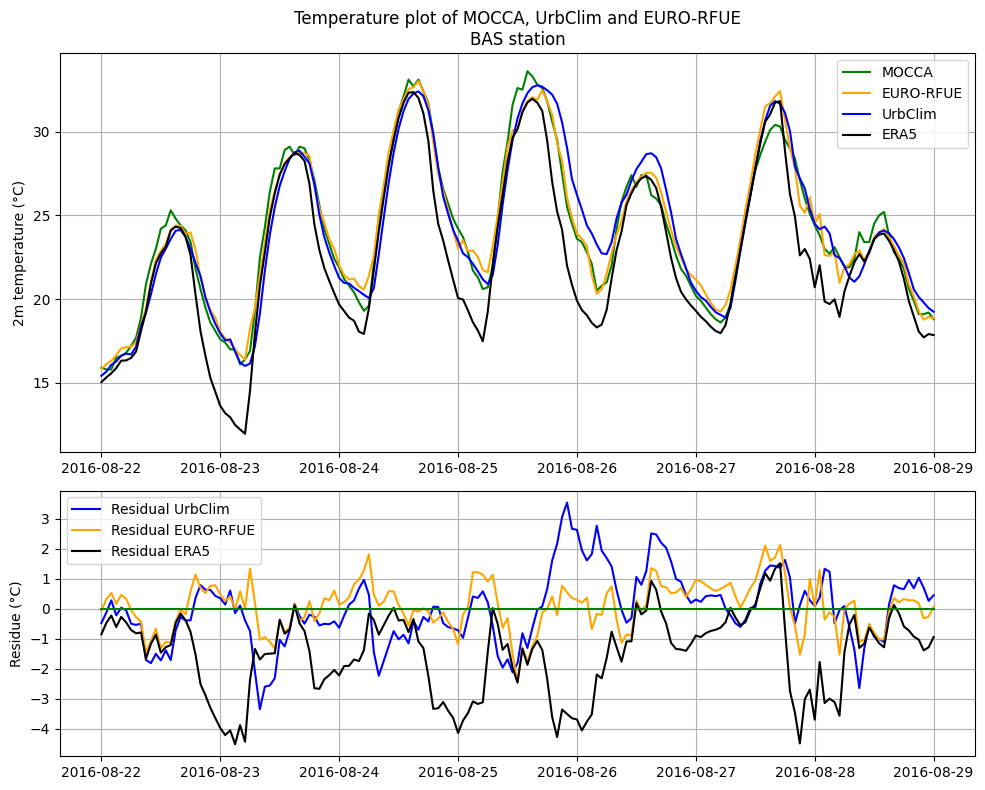

In [ ]:
import matplotlib.pyplot as plt
df = test[(test['x'] == 3.727799) & (test['y'] == 51.0512)]  #STATION BAS


import matplotlib.pyplot as plt

# Convert 'DateTime' column to datetime data type
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Filter data for the specified date range
start_date = '2016-08-22'
end_date = '2016-08-29'
filtered_data = df[(df['DateTime'] >= start_date) & (df['DateTime'] <= end_date)]

# Create figure and axes for both plots with adjusted height ratio
fig, (ax, residual_ax) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 2]})

# Plot Temperature, y_pred, and y_test on the upper plot
ax.plot(filtered_data['DateTime'], filtered_data['Temperature'], label='MOCCA', color='green')
ax.plot(filtered_data['DateTime'], filtered_data['y_pred'], label='EURO-RFUE', color='orange')
ax.plot(filtered_data['DateTime'], filtered_data['y_test'], label='UrbClim', color='blue')
ax.plot(filtered_data['DateTime'], filtered_data['ERA5'], label='ERA5', color='black')


# Customize upper plot
#ax.set_xlabel('Time')
ax.set_ylabel('2m temperature (°C)')
ax.set_title('Temperature plot of MOCCA, UrbClim and EURO-RFUE\nBAS station')
ax.legend()
ax.grid(True)

# Calculate residuals
residual_y_test = filtered_data['y_test'] - filtered_data['Temperature']
residual_y_pred = filtered_data['y_pred'] - filtered_data['Temperature']
residual_ERA5=filtered_data['ERA5'] - filtered_data['Temperature']
# Plot residuals on the lower plot
residual_ax.plot(filtered_data['DateTime'], residual_y_test, label='Residual UrbClim', color='blue')
residual_ax.plot(filtered_data['DateTime'], residual_y_pred, label='Residual EURO-RFUE', color='orange')
residual_ax.plot(filtered_data['DateTime'], residual_ERA5, label='Residual ERA5', color='black')

residual_ax.plot(filtered_data['DateTime'], residual_y_pred * 0.0, color='green')

# Customize lower plot
#residual_ax.set_xlabel('Time')
residual_ax.set_ylabel('Residue (°C)')
residual_ax.grid()
residual_ax.legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()



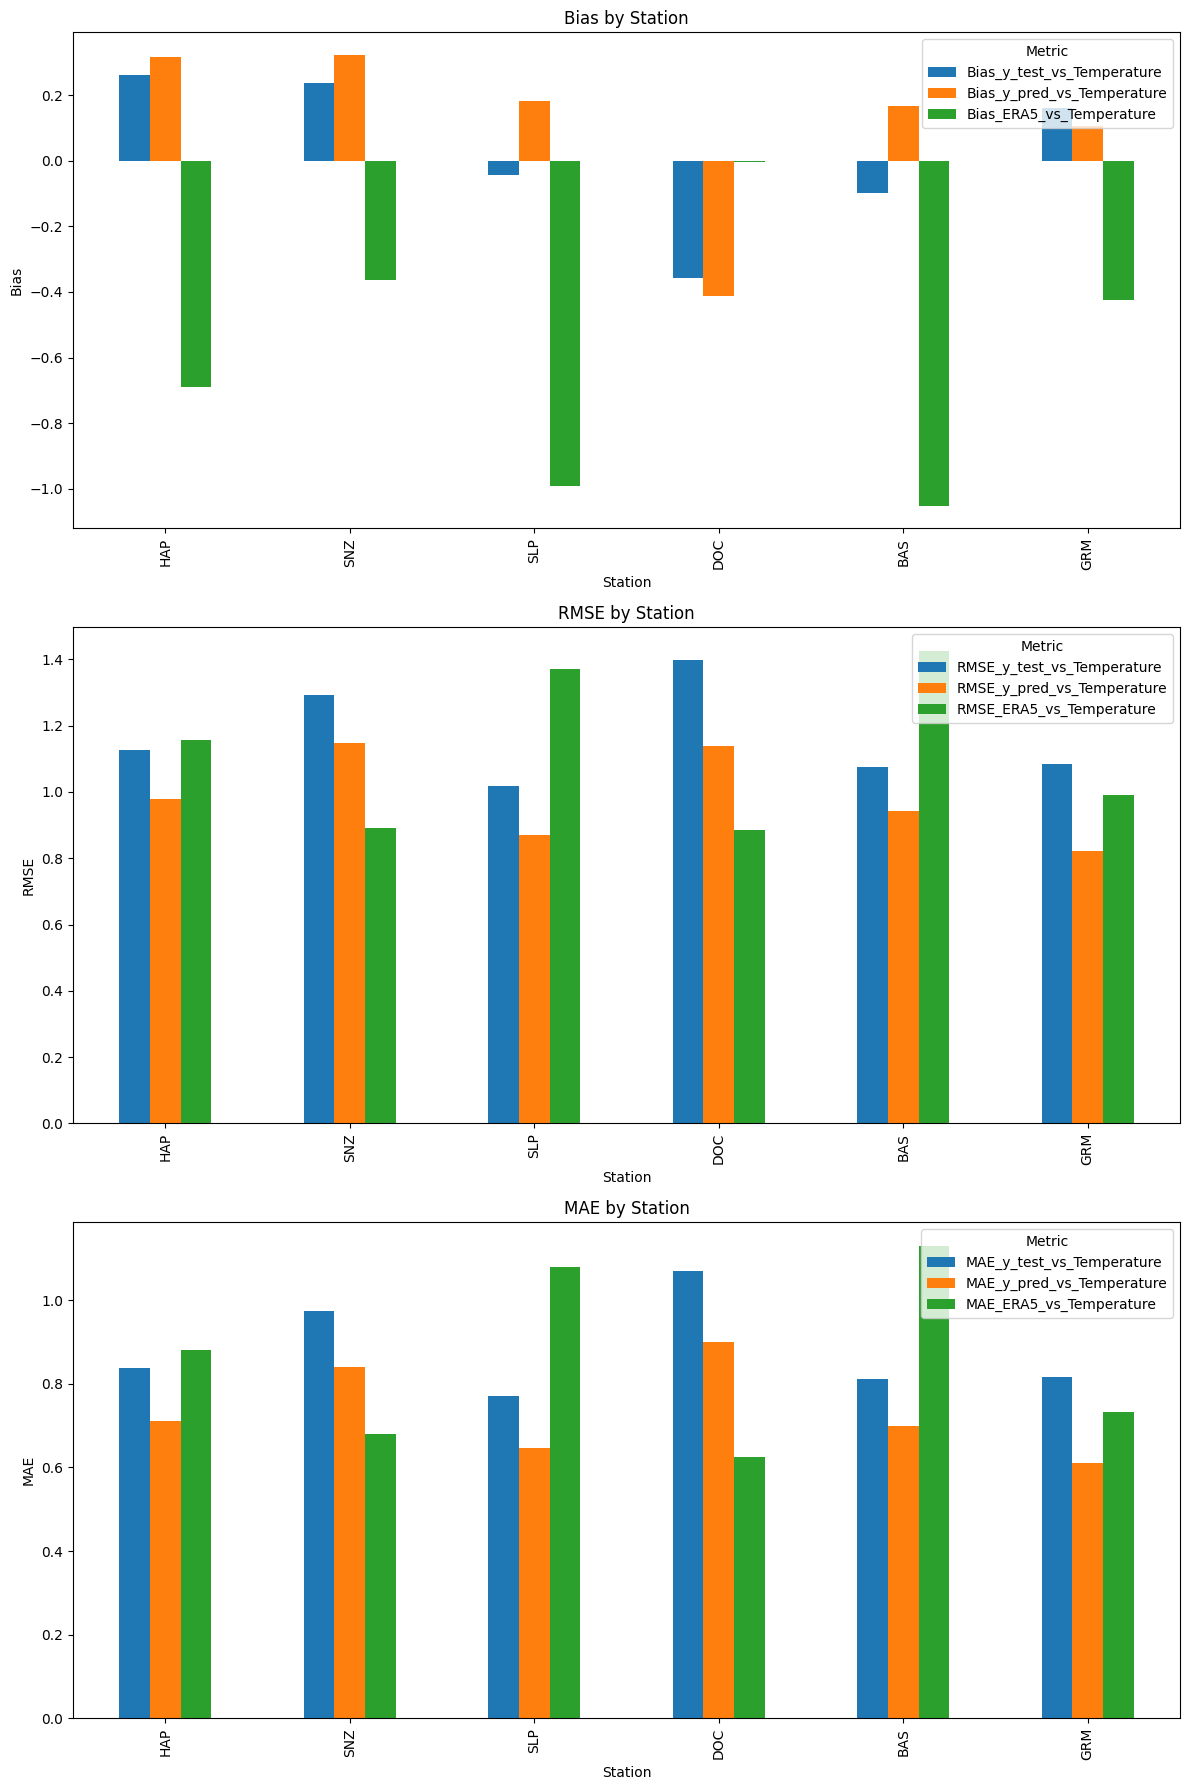

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
stations = test['Station'].unique()


# Initialize dictionaries to store metrics
rmse_dict = {}
mae_dict = {}
bias_dict = {}

for station in stations:
    station_data = test[test['Station'] == station]

    # Calculate Bias
    bias_y_pred_vs_y_test = np.mean(station_data['y_pred'] - station_data['y_test'])
    bias_y_test_vs_Temperature = np.mean(station_data['y_test'] - station_data['Temperature'])
    bias_y_pred_vs_Temperature = np.mean(station_data['y_pred'] - station_data['Temperature'])
    bias_ERA5_vs_Temperature = np.mean(station_data['ERA5'] - station_data['Temperature'])
    bias_dict[station] = [ bias_y_test_vs_Temperature, bias_y_pred_vs_Temperature, bias_ERA5_vs_Temperature]

    # Calculate RMSE
    rmse_y_pred_vs_y_test = np.sqrt(mean_squared_error(station_data['y_test'], station_data['y_pred']))
    rmse_y_test_vs_Temperature = np.sqrt(mean_squared_error(station_data['y_test'], station_data['Temperature']))
    rmse_y_pred_vs_Temperature = np.sqrt(mean_squared_error(station_data['y_pred'], station_data['Temperature']))
    rmse_ERA5_vs_Temperature = np.sqrt(mean_squared_error(station_data['ERA5'], station_data['Temperature']))
    rmse_dict[station] = [ rmse_y_test_vs_Temperature, rmse_y_pred_vs_Temperature, rmse_ERA5_vs_Temperature]

    # Calculate MAE
    mae_y_pred_vs_y_test = mean_absolute_error(station_data['y_test'], station_data['y_pred'])
    mae_y_test_vs_Temperature = mean_absolute_error(station_data['y_test'], station_data['Temperature'])
    mae_y_pred_vs_Temperature = mean_absolute_error(station_data['y_pred'], station_data['Temperature'])
    mae_ERA5_vs_Temperature = mean_absolute_error(station_data['ERA5'], station_data['Temperature'])
    mae_dict[station] = [ mae_y_test_vs_Temperature, mae_y_pred_vs_Temperature, mae_ERA5_vs_Temperature]

# Create DataFrame from dictionaries
bias_df = pd.DataFrame.from_dict(bias_dict, orient='index', columns=[ 'Bias_y_test_vs_Temperature', 'Bias_y_pred_vs_Temperature', 'Bias_ERA5_vs_Temperature'])
rmse_df = pd.DataFrame.from_dict(rmse_dict, orient='index', columns=[ 'RMSE_y_test_vs_Temperature', 'RMSE_y_pred_vs_Temperature', 'RMSE_ERA5_vs_Temperature'])
mae_df = pd.DataFrame.from_dict(mae_dict, orient='index', columns=[ 'MAE_y_test_vs_Temperature', 'MAE_y_pred_vs_Temperature', 'MAE_ERA5_vs_Temperature'])

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Bias
bias_df.plot(kind='bar', ax=axes[0])
axes[0].set_title('Bias by Station')
axes[0].set_ylabel('Bias')
axes[0].set_xlabel('Station')
axes[0].legend(title='Metric', loc='upper right')

# RMSE
rmse_df.plot(kind='bar', ax=axes[1])
axes[1].set_title('RMSE by Station')
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('Station')
axes[1].legend(title='Metric', loc='upper right')

# MAE
mae_df.plot(kind='bar', ax=axes[2])
axes[2].set_title('MAE by Station')
axes[2].set_ylabel('MAE')
axes[2].set_xlabel('Station')
axes[2].legend(title='Metric', loc='upper right')

plt.tight_layout()
plt.show()

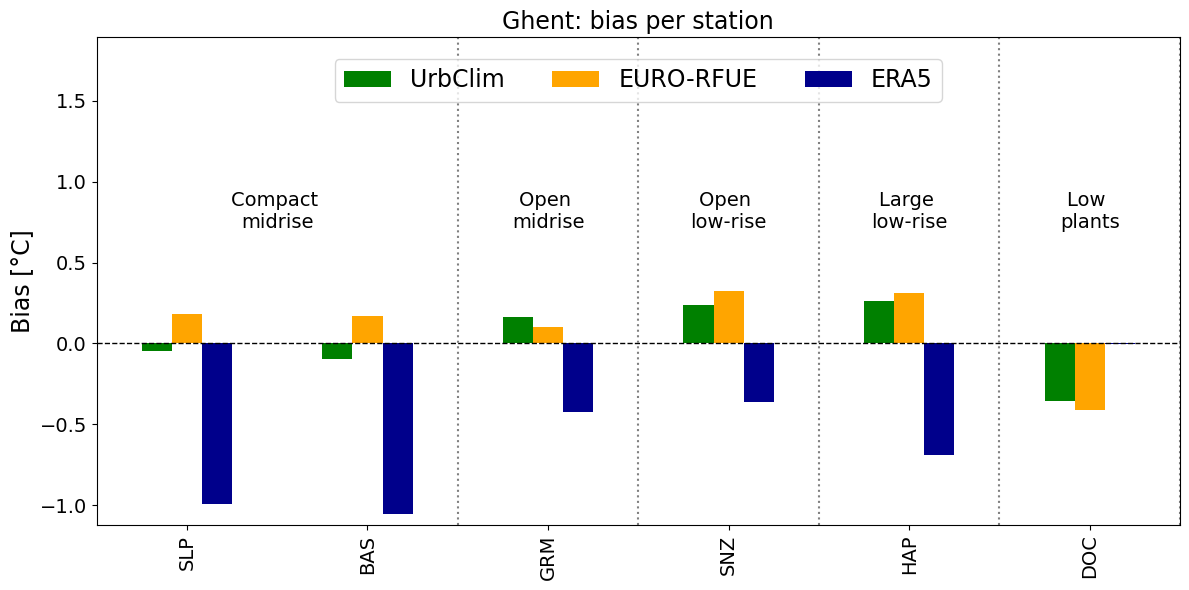

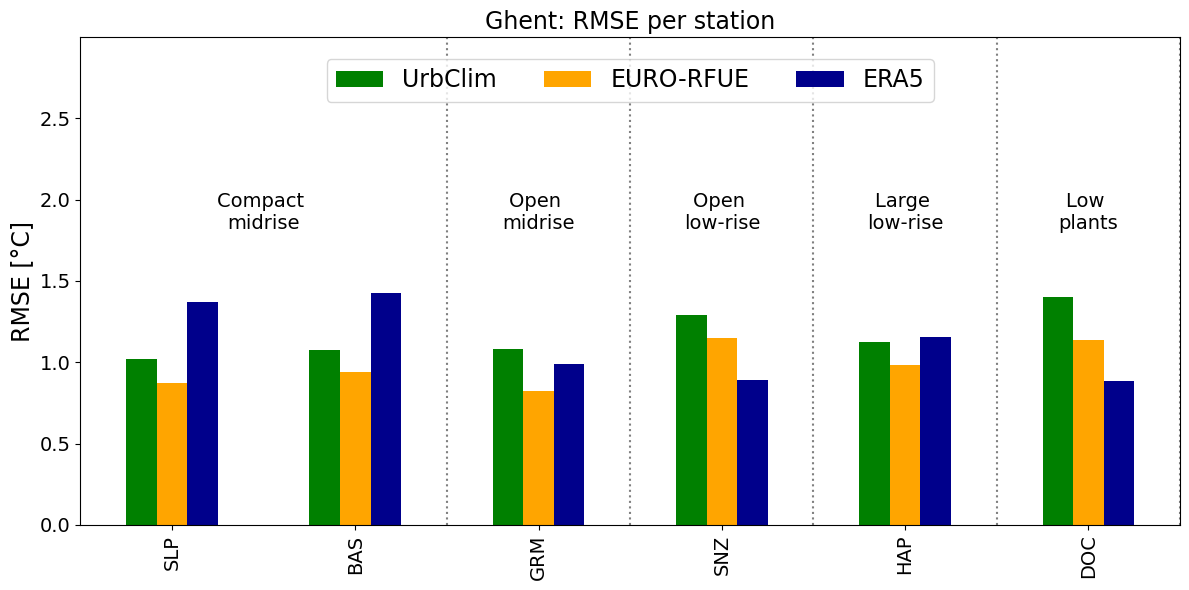

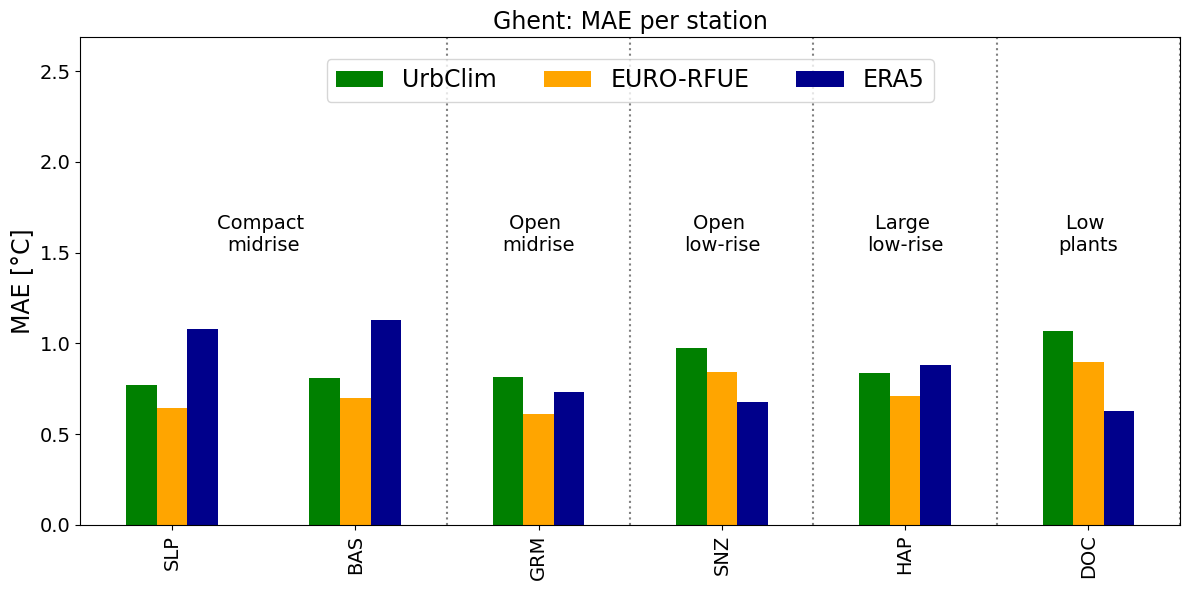

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Sort the test DataFrame by the LCZ column
test_sorted = test.sort_values(by='LCZ')

# Get the unique stations in the sorted order
stations_sorted = test_sorted['Station'].unique()

# Initialize dictionaries to store metrics
rmse_dict = {}
mae_dict = {}
bias_dict = {}

for station in stations_sorted:
    station_data = test_sorted[test_sorted['Station'] == station]

    # Calculate Bias
    bias_y_pred_vs_y_test = np.mean(station_data['y_pred'] - station_data['y_test'])
    bias_y_test_vs_Temperature = np.mean(station_data['y_test'] - station_data['Temperature'])
    bias_y_pred_vs_Temperature = np.mean(station_data['y_pred'] - station_data['Temperature'])
    bias_ERA5_vs_Temperature = np.mean(station_data['ERA5'] - station_data['Temperature'])
    bias_dict[station] = [bias_y_test_vs_Temperature, bias_y_pred_vs_Temperature, bias_ERA5_vs_Temperature]

    # Calculate RMSE
    rmse_y_pred_vs_y_test = np.sqrt(mean_squared_error(station_data['y_test'], station_data['y_pred']))
    rmse_y_test_vs_Temperature = np.sqrt(mean_squared_error(station_data['y_test'], station_data['Temperature']))
    rmse_y_pred_vs_Temperature = np.sqrt(mean_squared_error(station_data['y_pred'], station_data['Temperature']))
    rmse_ERA5_vs_Temperature = np.sqrt(mean_squared_error(station_data['ERA5'], station_data['Temperature']))
    rmse_dict[station] = [rmse_y_test_vs_Temperature, rmse_y_pred_vs_Temperature, rmse_ERA5_vs_Temperature]

    # Calculate MAE
    mae_y_pred_vs_y_test = mean_absolute_error(station_data['y_test'], station_data['y_pred'])
    mae_y_test_vs_Temperature = mean_absolute_error(station_data['y_test'], station_data['Temperature'])
    mae_y_pred_vs_Temperature = mean_absolute_error(station_data['y_pred'], station_data['Temperature'])
    mae_ERA5_vs_Temperature = mean_absolute_error(station_data['ERA5'], station_data['Temperature'])
    mae_dict[station] = [mae_y_test_vs_Temperature, mae_y_pred_vs_Temperature, mae_ERA5_vs_Temperature]

# Create DataFrame from dictionaries
bias_df = pd.DataFrame.from_dict(bias_dict, orient='index', columns=['Bias_y_test_vs_Temperature', 'Bias_y_pred_vs_Temperature', 'Bias_ERA5_vs_Temperature'])
rmse_df = pd.DataFrame.from_dict(rmse_dict, orient='index', columns=['RMSE_y_test_vs_Temperature', 'RMSE_y_pred_vs_Temperature', 'RMSE_ERA5_vs_Temperature'])
mae_df = pd.DataFrame.from_dict(mae_dict, orient='index', columns=['MAE_y_test_vs_Temperature', 'MAE_y_pred_vs_Temperature', 'MAE_ERA5_vs_Temperature'])

# Reorder the DataFrames according to sorted stations
bias_df = bias_df.loc[stations_sorted]
rmse_df = rmse_df.loc[stations_sorted]
mae_df = mae_df.loc[stations_sorted]

# Function to add vertical lines and labels for LCZ groups
def add_lcz_lines_and_labels(ax, test_sorted, stations_sorted):
    lczs_sorted = test_sorted['LCZ'].unique()
    lcz_labels = {
        1: 'Compact \nhigh-rise',
        2: 'Compact \nmidrise',
        3: 'Compact \nlow-rise',
        4: 'Open \nhigh-rise',
        5: 'Open \nmidrise',
        6: 'Open \nlow-rise',
        7: 'Lightweight \nlow-rise',
        8: 'Large \nlow-rise',
        9: 'Sparsely \nbuilt',
        10: 'Heavy \nindustry',
        11: 'Dense \ntrees',
        12: 'Scattered \ntrees',
        13: 'Bush, scrub',
        14: 'Low \nplants',
        15: 'Bare rock \nor paved',
        16: 'Bare soil \nor sand',
        17: 'Water'
    }
    x_ticks = ax.get_xticks()
    for i, lcz in enumerate(lczs_sorted):
        group = test_sorted[test_sorted['LCZ'] == lcz]['Station'].unique()
        cumulative_position = sum(test_sorted[test_sorted['LCZ'] == lczs_sorted[j]]['Station'].unique().size for j in range(i + 1)) - 1
        if cumulative_position + 0.5 < len(x_ticks):
            ax.axvline(x=cumulative_position + 0.5, color='gray', linestyle='dotted')
            ax.text((cumulative_position - len(group) / 2) + 0.5, max(ax.get_ylim()) - 1.2, lcz_labels[lcz], ha='center', va='bottom', fontsize=14, color='black', rotation=0)
colors = ['green', 'orange', 'darkblue']

# Plotting Bias
fig, ax_bias = plt.subplots(figsize=(12, 6))
bias_df.plot(kind='bar', ax=ax_bias, color=colors)
ax_bias.set_title('Ghent: bias per station', fontsize=17)
ax_bias.set_ylabel('Bias [°C]', fontsize=17)
ax_bias.legend(labels=['UrbClim', 'EURO-RFUE', 'ERA5'], loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=3, fontsize=17)
ax_bias.axhline(y=0, color='k', linestyle='--', linewidth=1)
ax_bias.tick_params(axis='both', which='major', labelsize=14)
ylim_bias = ax_bias.get_ylim()
ax_bias.set_ylim(ylim_bias[0], ylim_bias[1] + 1.5)
add_lcz_lines_and_labels(ax_bias, test_sorted, stations_sorted)
plt.tight_layout()
plt.show()

# Plotting RMSE
fig, ax_rmse = plt.subplots(figsize=(12, 6))
rmse_df.plot(kind='bar', ax=ax_rmse, color=colors)
ax_rmse.set_title('Ghent: RMSE per station', fontsize=17)
ax_rmse.set_ylabel('RMSE [°C]', fontsize=17)
ax_rmse.legend(labels=['UrbClim', 'EURO-RFUE', 'ERA5'], loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=3, fontsize=17)
ylim_rmse = ax_rmse.get_ylim()
ax_rmse.set_ylim(ylim_rmse[0], ylim_rmse[1] + 1.5)
ax_rmse.tick_params(axis='both', which='major', labelsize=14)
add_lcz_lines_and_labels(ax_rmse, test_sorted, stations_sorted)
plt.tight_layout()
plt.show()

# Plotting MAE
fig, ax_mae = plt.subplots(figsize=(12, 6))
mae_df.plot(kind='bar', ax=ax_mae, color=colors)
ax_mae.set_title('Ghent: MAE per station', fontsize=17)
ax_mae.set_ylabel('MAE [°C]', fontsize=17)
ax_mae.legend(labels=['UrbClim', 'EURO-RFUE', 'ERA5'], loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=3, fontsize=17)
ylim_mae = ax_mae.get_ylim()
ax_mae.set_ylim(ylim_mae[0], ylim_mae[1] + 1.5)
ax_mae.tick_params(axis='both', which='major', labelsize=14)
add_lcz_lines_and_labels(ax_mae, test_sorted, stations_sorted)
plt.tight_layout()
plt.show()


In [ ]:
test['LCZ'].unique()
# Display the unique LCZ values
unique_lcz = test['LCZ'].unique()
print("Unique LCZ values:", unique_lcz)

# Count the number of stations per LCZ
stations_per_lcz = test.groupby('LCZ')['Station'].nunique()
print("Number of stations per LCZ:\n", stations_per_lcz)



Unique LCZ values: [ 8  6  2 14  5]
Number of stations per LCZ:
 LCZ
2     2
5     1
6     1
8     1
14    1
Name: Station, dtype: int64


<ipython-input-39-c2eec67e18a4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Hour'] = filtered_data['DateTime'].dt.hour
<ipython-input-39-c2eec67e18a4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Hour'] = data_filtered['DateTime'].dt.hour


Hour: 0
51168   -17.400768
51888   -17.400768
52608   -17.400768
53328   -17.400768
54048   -17.400768
54768   -17.400768
Name: SOLAR_ELEV, dtype: float64
Hour: 1
51169   -15.860426
51889   -15.860426
52609   -15.860426
53329   -15.860426
54049   -15.860426
54769   -15.860426
Name: SOLAR_ELEV, dtype: float64
Hour: 2
51170   -12.091775
51890   -12.091775
52610   -12.091775
53330   -12.091775
54050   -12.091775
54770   -12.091775
Name: SOLAR_ELEV, dtype: float64
Hour: 3
51171   -6.427952
51891   -6.427952
52611   -6.427952
53331   -6.427952
54051   -6.427952
54771   -6.427952
Name: SOLAR_ELEV, dtype: float64
Hour: 4
51172    0.723731
51892    0.723731
52612    0.723731
53332    0.723731
54052    0.723731
54772    0.723731
Name: SOLAR_ELEV, dtype: float64
Hour: 5
51173    8.962299
51893    8.962299
52613    8.962299
53333    8.962299
54053    8.962299
54773    8.962299
Name: SOLAR_ELEV, dtype: float64
Hour: 6
51174    17.923576
51894    17.923576
52614    17.923576
53334    17.923576
5405

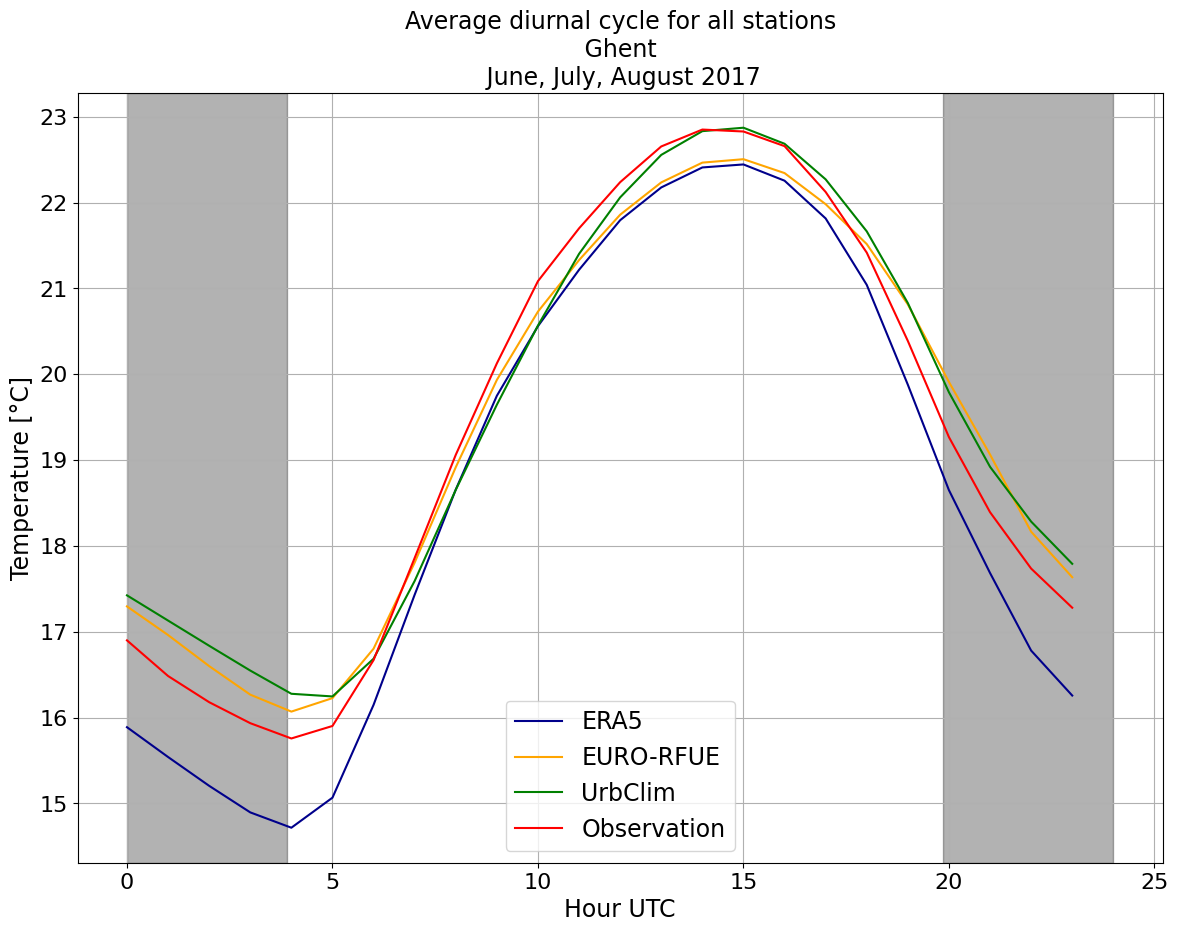

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `test` is your DataFrame
# Convert DateTime column to datetime type
test['DateTime'] = pd.to_datetime(test['DateTime'])

# Filter data for the months July, August, September and year 2017
data_filtered = test[(test['DateTime'].dt.year == 2017) &
                     (test['DateTime'].dt.month.isin([6, 7, 8]))]

# Filter data for the 15th of July, 2017
filtered_data = test[(test['DateTime'].dt.year == 2017) &
                     (test['DateTime'].dt.month == 7) &
                     (test['DateTime'].dt.day == 15)]

# Extract the hour from the DateTime for grouping
filtered_data['Hour'] = filtered_data['DateTime'].dt.hour

# Group by hour and print the SOLAR_ELEV values
for hour, group in filtered_data.groupby('Hour'):
    print(f"Hour: {hour}")
    print(group['SOLAR_ELEV'])

# Extract hour of the day for grouping
data_filtered['Hour'] = data_filtered['DateTime'].dt.hour

# Select only numeric columns and the grouping columns
numeric_columns = ['T2M', 'y_pred', 'y_test', 'Temperature']
grouping_columns = ['Hour']

# Group data by Hour and calculate the mean for numeric columns
grouped = data_filtered[grouping_columns + numeric_columns].groupby(['Hour']).mean().reset_index()

# Plotting the average diurnal cycle for all stations
plt.figure(figsize=(14, 10))

colors = ['darkblue', 'orange', 'green', 'red']
linestyles = ['-', '-', '-', '-']

for i, var in enumerate(numeric_columns):
    plt.plot(grouped['Hour'], grouped[var], label=var, color=colors[i], linestyle=linestyles[i])

plt.title('Average diurnal cycle for all stations\n Ghent \n June, July, August 2017', fontsize=17)
plt.xlabel('Hour UTC', fontsize=17)
plt.ylabel('Temperature [°C]', fontsize=17)

# Define nighttime shading
start_night = 19.85  # 20:00
end_night = 3.9  # 04:00

plt.axvspan(start_night, 24, color='k', alpha=0.3)  # Night starts at 20:00
plt.axvspan(0, end_night, color='k', alpha=0.3)  # Night ends at 04:00
plt.tick_params(axis='both', which='major', labelsize=16)

plt.legend(labels=['ERA5', 'EURO-RFUE', 'UrbClim' ,'Observation' ], fontsize=17)
plt.grid(True)
plt.show()


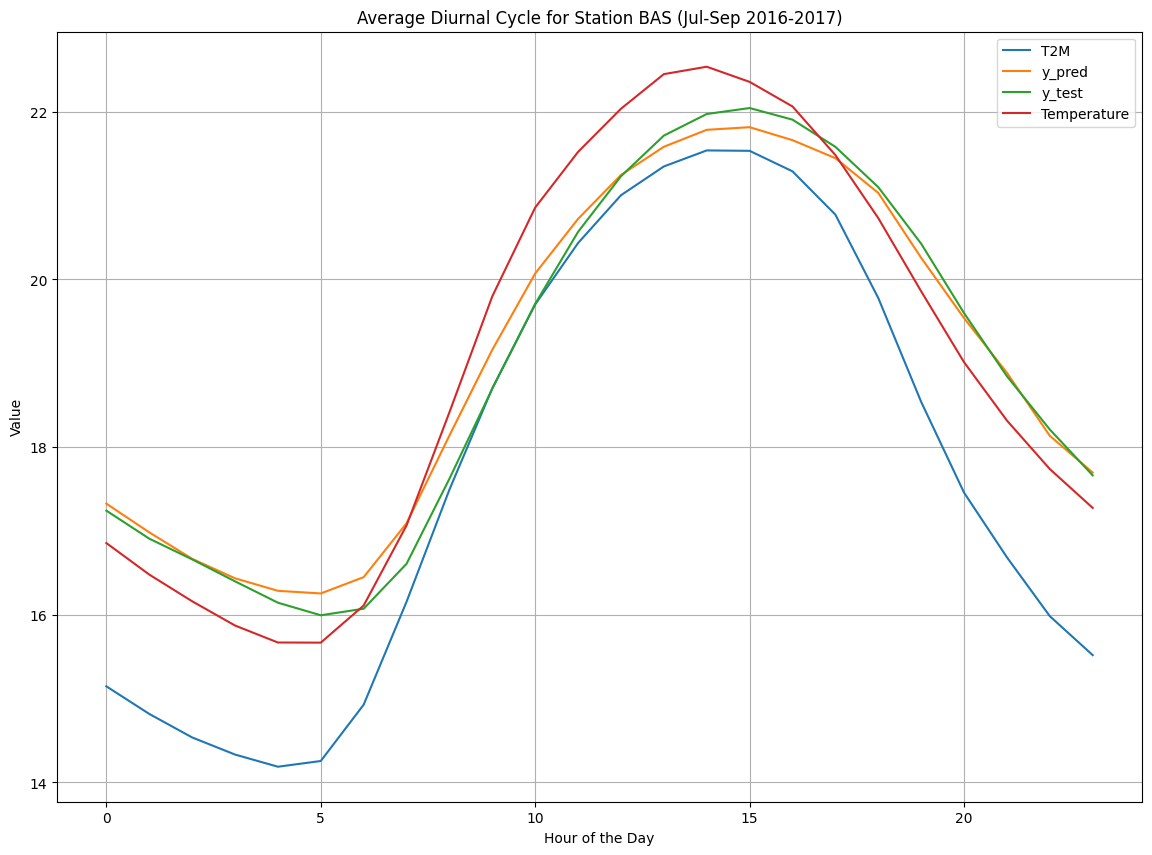

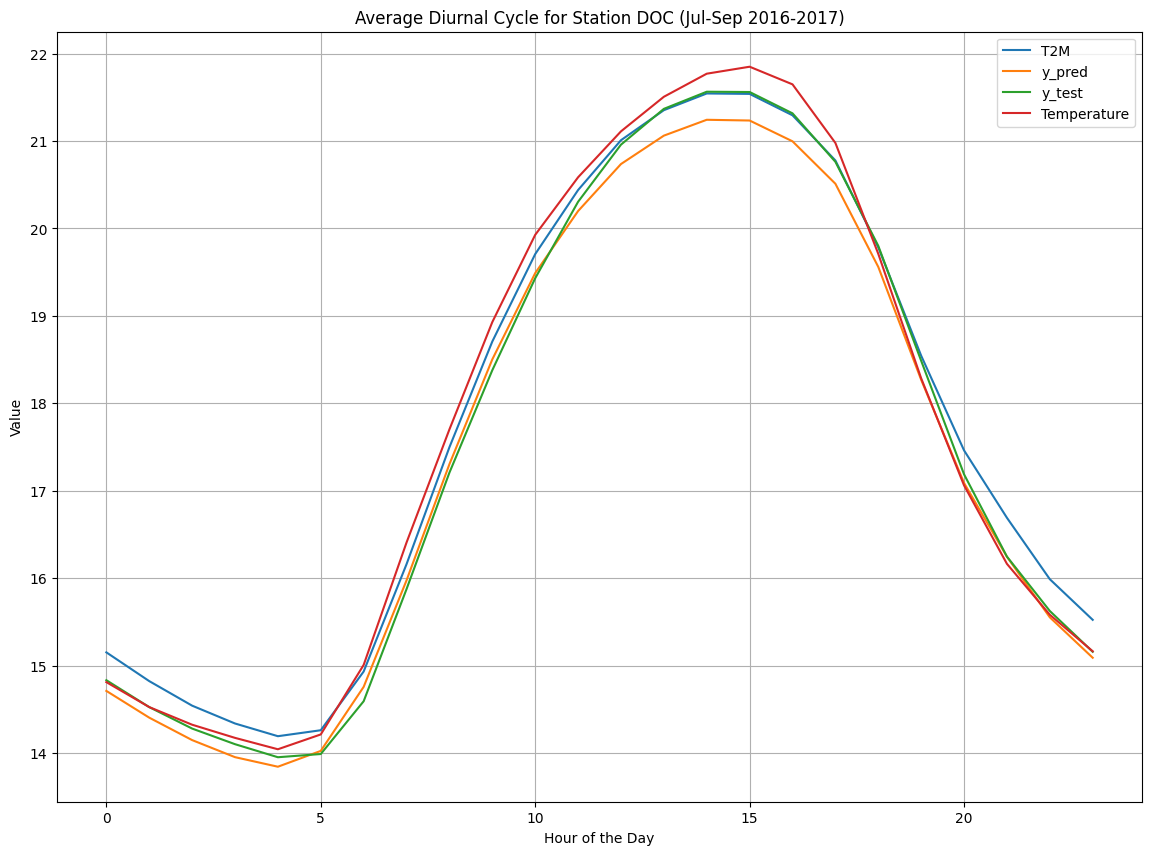

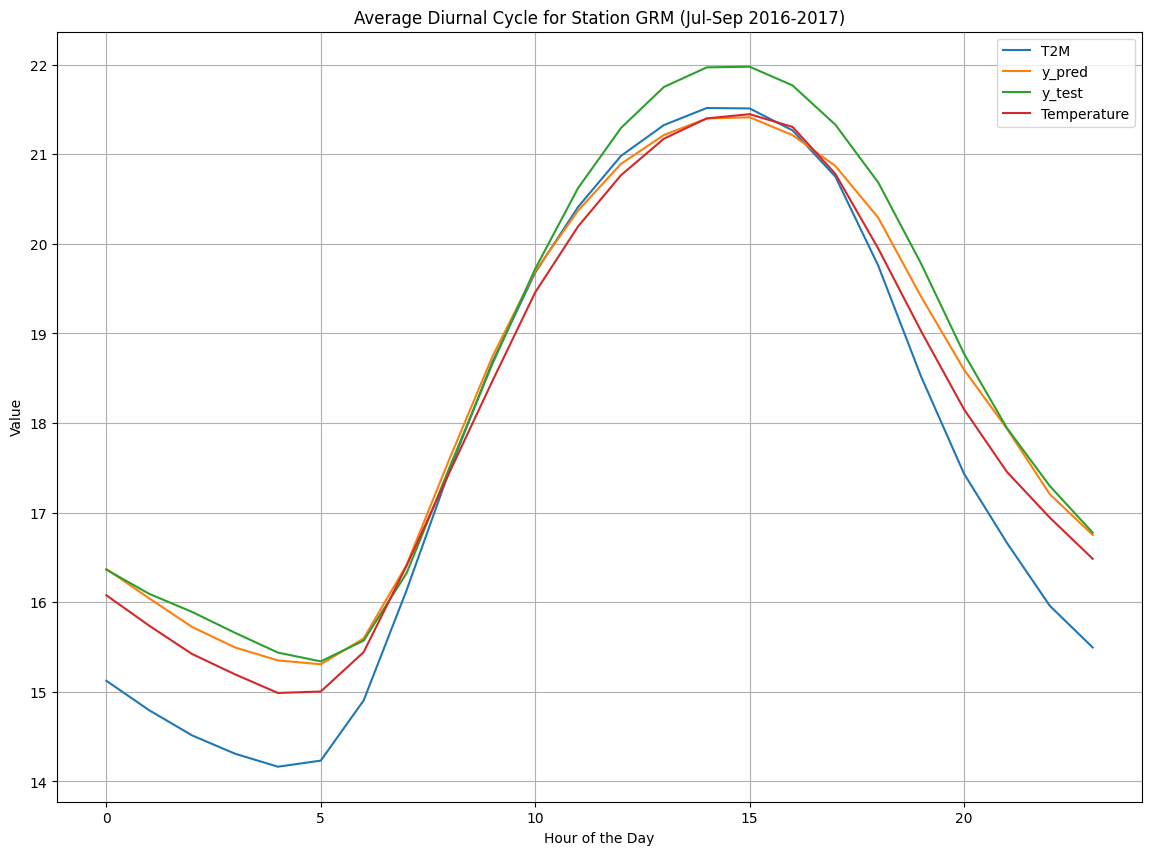

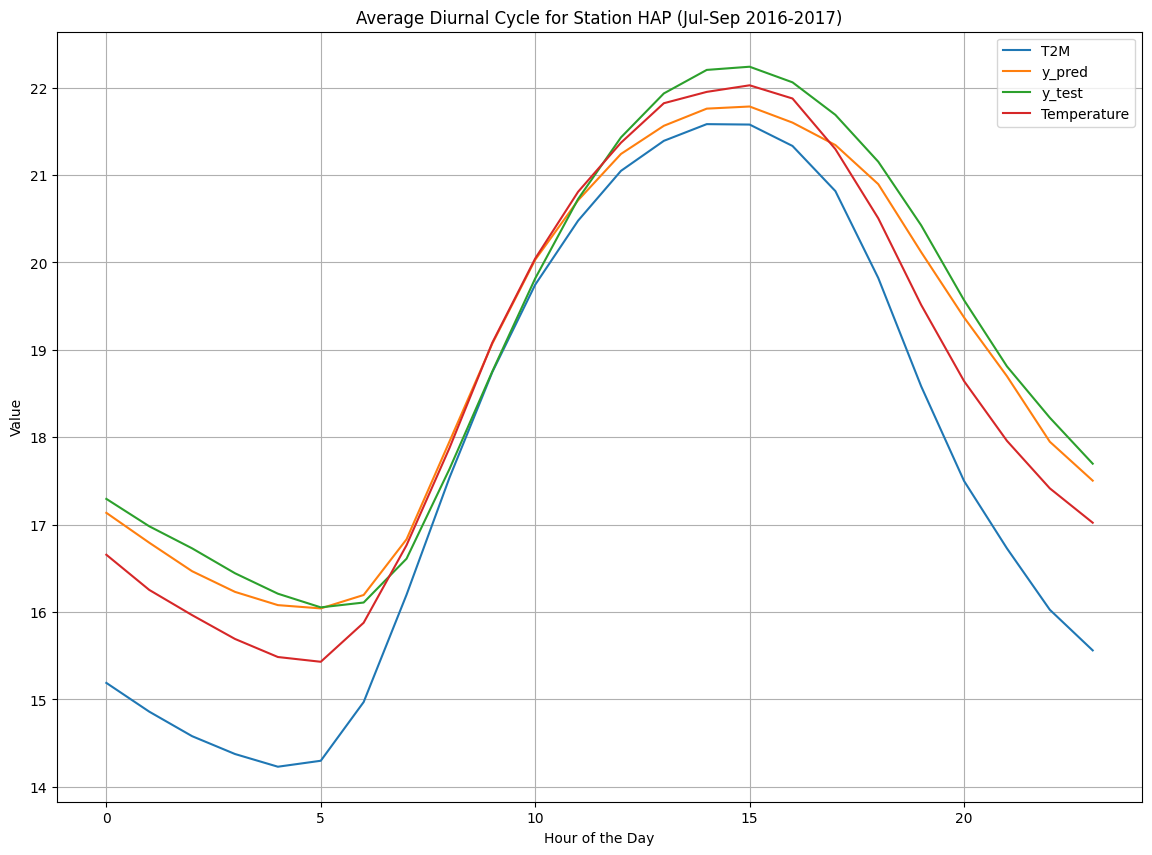

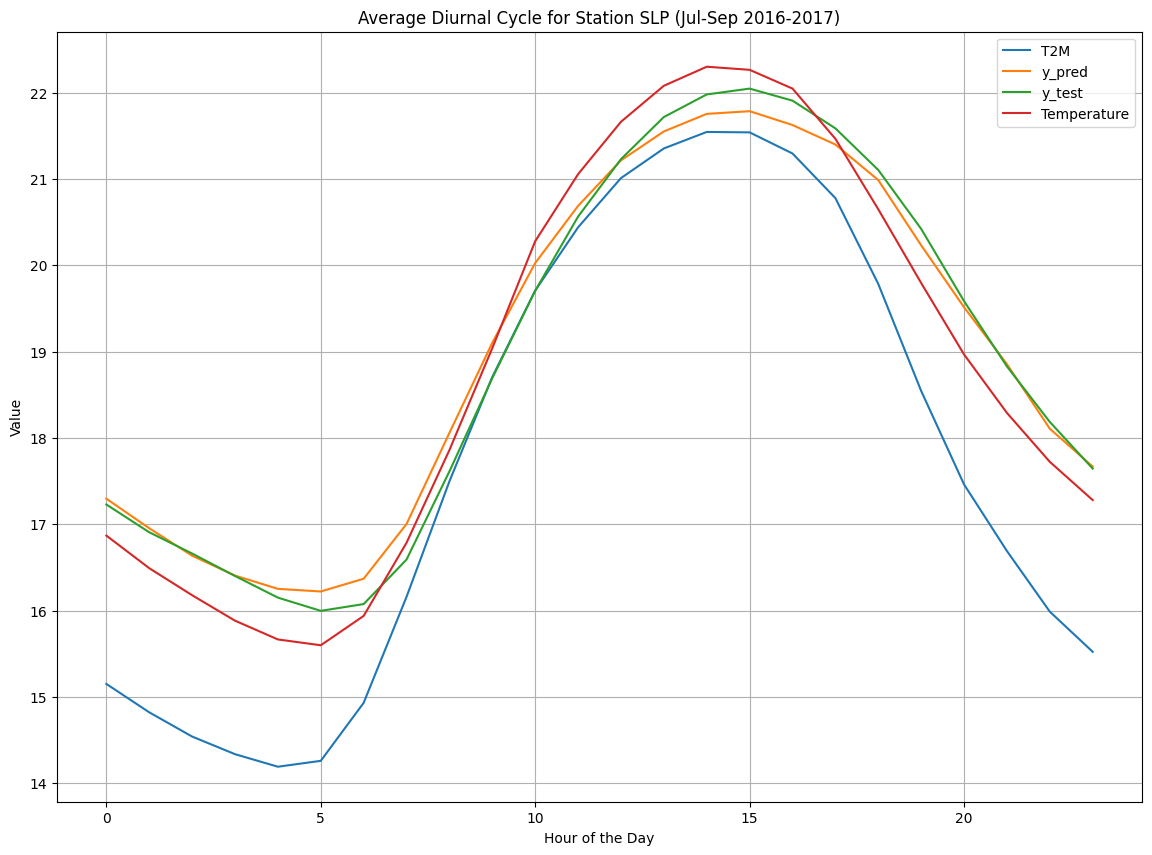

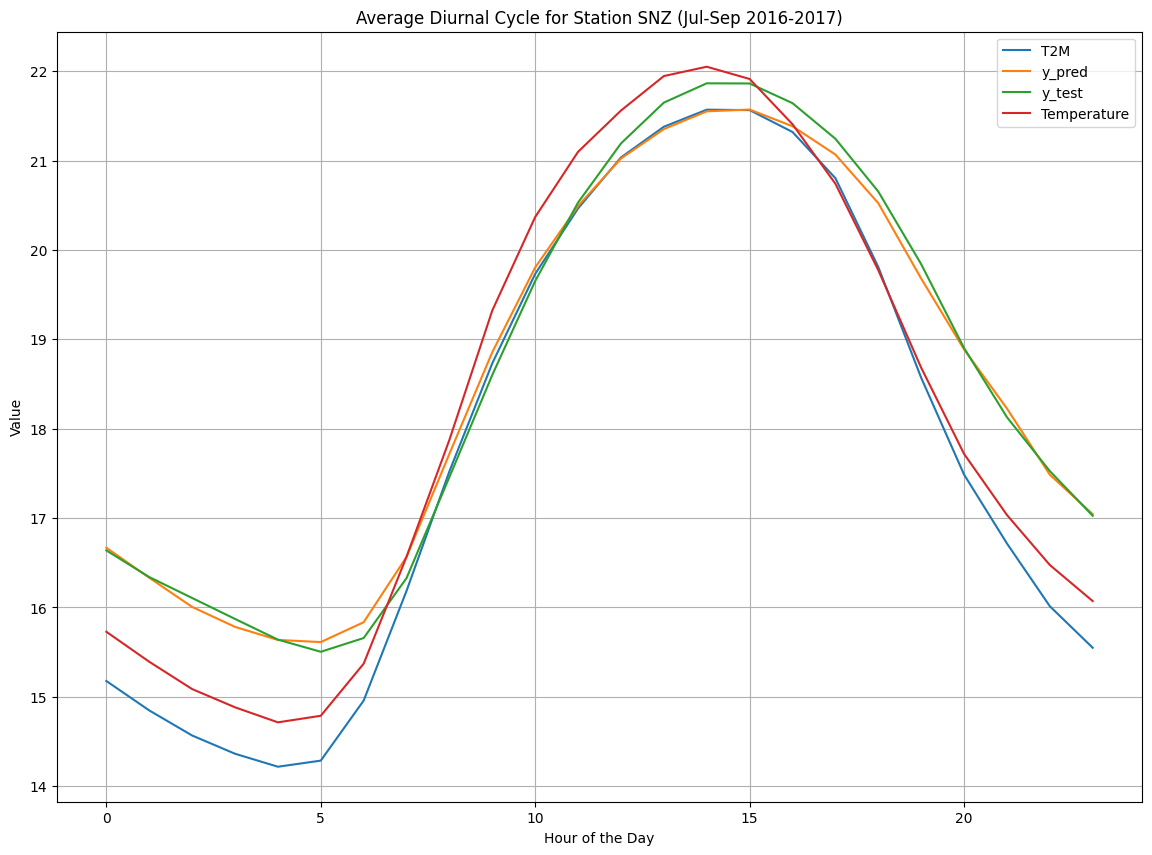

In [ ]:
data=test

import pandas as pd
import matplotlib.pyplot as plt

# Convert DateTime column to datetime type
data['DateTime'] = pd.to_datetime(data['DateTime'])

# Filter data for the months July, August, September and years 2016-2017
data_filtered = data[(data['DateTime'].dt.year.isin([2016, 2017])) &
                     (data['DateTime'].dt.month.isin([7, 8, 9]))]

# Extract hour of the day for grouping
data_filtered = data_filtered.copy()
data_filtered['Hour'] = data_filtered['DateTime'].dt.hour

# Select only numeric columns and the grouping columns
numeric_columns = ['T2M', 'y_pred', 'y_test', 'Temperature']
grouping_columns = ['Station', 'Hour']

# Group data by Station and Hour and calculate the mean for numeric columns
grouped = data_filtered[grouping_columns + numeric_columns].groupby(['Station', 'Hour']).mean().reset_index()

# Plotting the average diurnal cycle for each station
stations = grouped['Station'].unique()

for station in stations:
    plt.figure(figsize=(14, 10))
    station_data = grouped[grouped['Station'] == station]

    for var in numeric_columns:
        plt.plot(station_data['Hour'], station_data[var], label=var)

    plt.title(f'Average Diurnal Cycle for Station {station} (Jul-Sep 2016-2017)')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
test_rainy_day = test[(test['SOLAR_ELEV'] > 0) & (test['PRECIP'] > 0.001)]
test_dry_day = test[(test['SOLAR_ELEV'] > 0) & (test['PRECIP'] < 0.001)]
test_rainy_night = test[(test['SOLAR_ELEV'] < 0) & (test['PRECIP'] > 0.001)]
test_dry_night = test[(test['SOLAR_ELEV'] < 0) & (test['PRECIP'] < 0.001)]
test_cloudy_day = test[(test['SOLAR_ELEV'] > 0) & (test['TCC'] > 0.5)]
test_clear_day = test[(test['SOLAR_ELEV'] > 0) & (test['TCC'] < 0.5)]
test_cloudy_night = test[(test['SOLAR_ELEV'] < 0) & (test['TCC'] > 0.5)]
test_clear_night = test[(test['SOLAR_ELEV'] < 0) & (test['TCC'] < 0.5)]
test_windy_day = test[(test['SOLAR_ELEV'] > 0) & (test['WS'] > 4)]
test_calm_day = test[(test['SOLAR_ELEV'] > 0) & (test['WS'] < 4)]
test_windy_night = test[(test['SOLAR_ELEV'] < 0) & (test['WS'] > 4)]
test_calm_night = test[(test['SOLAR_ELEV'] < 0) & (test['WS'] < 4)]


,index,SP,y_urb,x_urb,time,BLH,PRECIP,T_TARGET,T2M_NC,SSR,...,DateTime,Temperature,Label,Station,T2M_difference,y_pred,y_test,ERA5,Year,Month
4,4.0,100922.080,51.108624,3.749461,2016-07-01 04:00:00,1041.67590,0.037383,290.42550,16.98892,2422.875,...,2016-07-01 04:00:00,17.0,observation,HAP,0.20495,17.550963,17.27550,17.07055,2016,7
5,5.0,100941.430,51.108624,3.749461,2016-07-01 05:00:00,1075.84290,0.010189,290.39650,17.01135,59707.875,...,2016-07-01 05:00:00,16.3,observation,HAP,0.15352,17.515077,17.24650,17.09298,2016,7
6,6.0,100954.640,51.108624,3.749461,2016-07-01 06:00:00,1047.04750,0.057789,290.62610,17.08383,197106.000,...,2016-07-01 06:00:00,16.9,observation,HAP,0.31064,17.577256,17.47610,17.16546,2016,7
7,7.0,100973.516,51.108624,3.749461,2016-07-01 07:00:00,918.04080,1.526428,291.04852,17.01568,412463.500,...,2016-07-01 07:00:00,17.2,observation,HAP,0.80122,17.437451,17.89852,17.09730,2016,7
8,8.0,100980.125,51.108624,3.749461,2016-07-01 08:00:00,932.57056,1.138868,291.37076,17.08297,530264.100,...,2016-07-01 08:00:00,17.3,observation,HAP,1.05616,17.480970,18.22076,17.16460,2016,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76451,25907.0,99416.234,51.035133,3.721903,2017-12-30 11:00:00,1347.41040,0.000005,285.07193,12.62350,362766.060,...,2017-12-30 11:00:00,12.9,observation,GRM,-0.71777,12.583921,11.92193,12.63970,2017,12
76452,25908.0,99514.960,51.035133,3.721903,2017-12-30 12:00:00,1325.80270,0.000005,285.32250,12.84564,427019.380,...,2017-12-30 12:00:00,13.0,observation,GRM,-0.68934,12.770273,12.17250,12.86184,2017,12
76453,25909.0,99581.300,51.035133,3.721903,2017-12-30 13:00:00,1258.14420,0.000005,285.36377,12.90237,467015.620,...,2017-12-30 13:00:00,13.2,observation,GRM,-0.70480,12.590669,12.21377,12.91857,2017,12
76454,25910.0,99722.700,51.035133,3.721903,2017-12-30 14:00:00,1413.89560,0.000005,285.07820,12.73693,295359.000,...,2017-12-30 14:00:00,13.0,observation,GRM,-0.82494,12.469846,11.92820,12.75314,2017,12


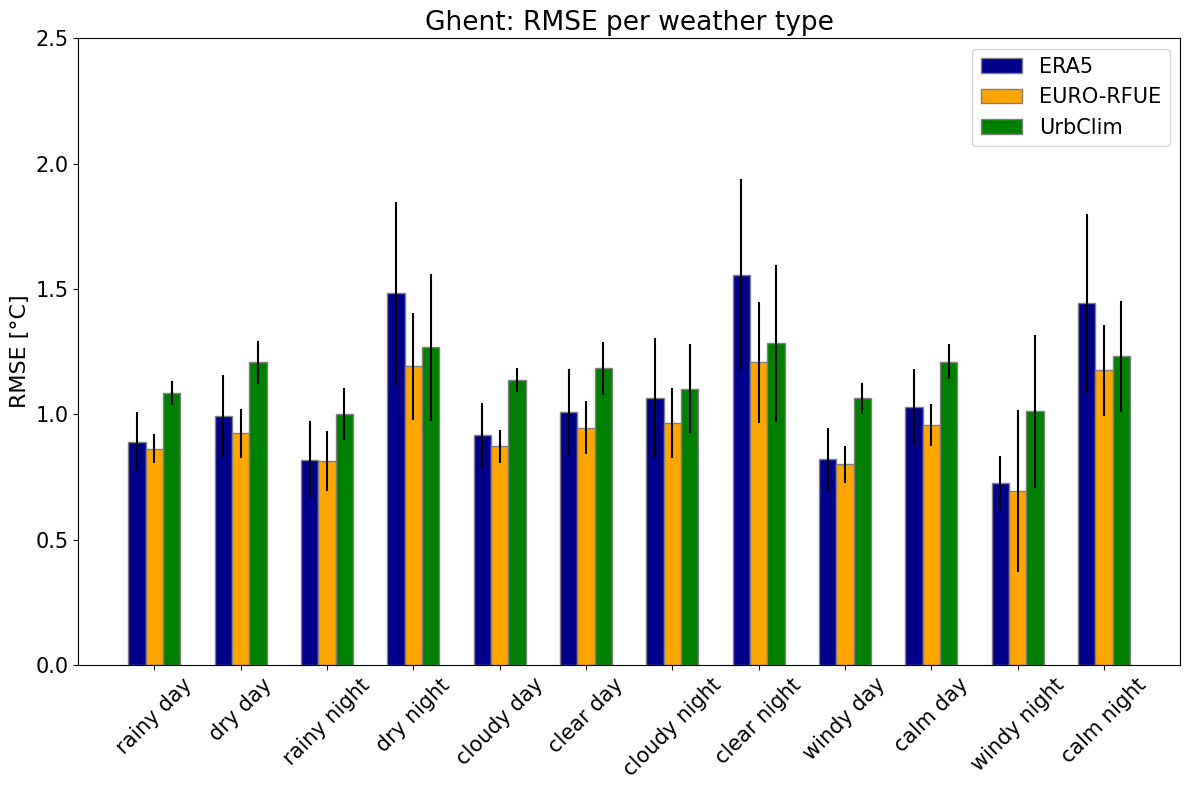

In [ ]:
# Create lists to store RMSEs for each weather type
RMSEs = []
# Define weather types
weather_types = ['rainy_day', 'dry_day', 'rainy_night', 'dry_night', 'cloudy_day', 'clear_day', 'cloudy_night', 'clear_night', 'windy_day', 'calm_day', 'windy_night', 'calm_night']

# Create lists to store RMSEs for each weather type
RMSEs = []

# Calculate RMSEs for each weather type

# Here we generate random RMSE values for demonstration
RMSE_ERA5_list = []
RMSE_y_pred_list = []
RMSE_y_test_list = []

SD_ERA5_list = []
SD_y_pred_list = []
SD_y_test_list = []

for weather_type in weather_types:
    filtered_data = globals()['test_' + weather_type]

    RMSE_ERA5_weather = []
    RMSE_y_pred_weather = []
    RMSE_y_test_weather = []

    for station in filtered_data['Station'].unique():
        station_data = filtered_data[filtered_data['Station'] == station]

        RMSE_ERA5 = np.sqrt(np.mean((station_data['ERA5'] - station_data['Temperature'])**2))
        RMSE_y_pred = np.sqrt(np.mean((station_data['y_pred'] - station_data['Temperature'])**2))
        RMSE_y_test = np.sqrt(np.mean((station_data['y_test'] - station_data['Temperature'])**2))

        RMSE_ERA5_weather.append(RMSE_ERA5)
        RMSE_y_pred_weather.append(RMSE_y_pred)
        RMSE_y_test_weather.append(RMSE_y_test)

    RMSE_ERA5_list.append(np.mean(RMSE_ERA5_weather))
    RMSE_y_pred_list.append(np.mean(RMSE_y_pred_weather))
    RMSE_y_test_list.append(np.mean(RMSE_y_test_weather))

    # Calculate standard deviations (SDs) for error bars
    SD_ERA5_list.append(np.std(RMSE_ERA5_weather))
    SD_y_pred_list.append(np.std(RMSE_y_pred_weather))
    SD_y_test_list.append(np.std(RMSE_y_test_weather))

# Convert lists to NumPy arrays for easier indexing
RMSE_ERA5_list = np.array(RMSE_ERA5_list)
RMSE_y_pred_list = np.array(RMSE_y_pred_list)
RMSE_y_test_list = np.array(RMSE_y_test_list)

SD_ERA5_list = np.array(SD_ERA5_list)
SD_y_pred_list = np.array(SD_y_pred_list)
SD_y_test_list = np.array(SD_y_test_list)

# Plotting RMSEs with error bars
fig, ax = plt.subplots(figsize=(12, 8))

barWidth = 0.2
r1 = np.arange(len(weather_types))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

colors = ['darkblue', 'orange', 'green']
labels = ['ERA5', 'EURO-RFUE', 'UrbClim']

# Plotting with error bars using SDs
ax.bar(r1, RMSE_ERA5_list, color=colors[0], width=barWidth, edgecolor='grey', label=labels[0], yerr=SD_ERA5_list)
ax.bar(r2, RMSE_y_pred_list, color=colors[1], width=barWidth, edgecolor='grey', label=labels[1], yerr=SD_y_pred_list)
ax.bar(r3, RMSE_y_test_list, color=colors[2], width=barWidth, edgecolor='grey', label=labels[2], yerr=SD_y_test_list)

weather_types_labels = ['rainy day', 'dry day', 'rainy night', 'dry night',
                 'cloudy day', 'clear day', 'cloudy night', 'clear night',
                 'windy day', 'calm day', 'windy night', 'calm night']

ax.set_xticks(r2)
ax.set_xticklabels(weather_types_labels, rotation=45, fontsize=15)
ax.tick_params(axis='y', labelsize=15)  # Set yticks font size

ax.set_ylabel('RMSE [°C]', fontsize=16)
ax.set_title('Ghent: RMSE per weather type', fontsize=19)
ax.set_ylim(0, 2.5)
ax.legend(fontsize=15)

plt.tight_layout()
plt.show()

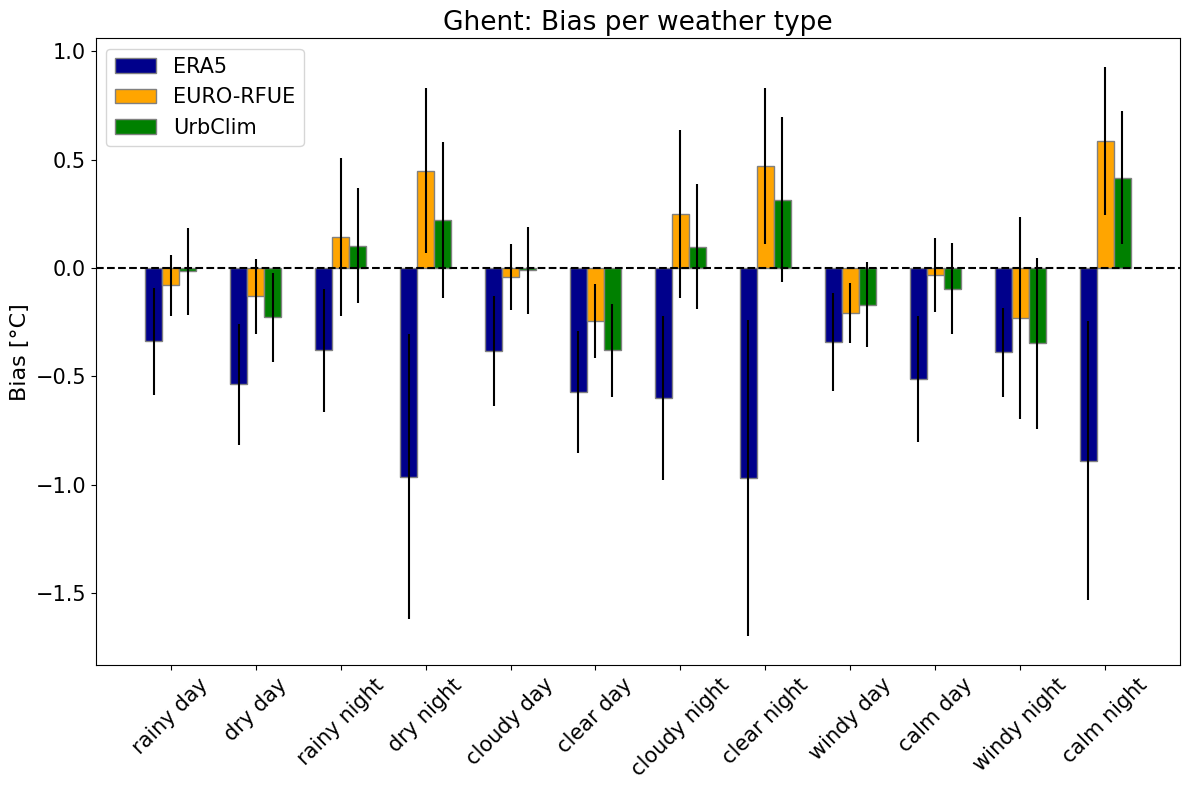

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume you have already defined `weather_types` and have data for each weather type

# Create lists to store biases for each weather type
Bias_ERA5_list = []
Bias_y_pred_list = []
Bias_y_test_list = []

SD_Bias_ERA5_list = []
SD_Bias_y_pred_list = []
SD_Bias_y_test_list = []

for weather_type in weather_types:
    filtered_data = globals()['test_' + weather_type]

    Bias_ERA5_weather = []
    Bias_y_pred_weather = []
    Bias_y_test_weather = []

    for station in filtered_data['Station'].unique():
        station_data = filtered_data[filtered_data['Station'] == station]

        Bias_ERA5 = np.mean(station_data['ERA5'] - station_data['Temperature'])
        Bias_y_pred = np.mean(station_data['y_pred'] - station_data['Temperature'])
        Bias_y_test = np.mean(station_data['y_test'] - station_data['Temperature'])

        Bias_ERA5_weather.append(Bias_ERA5)
        Bias_y_pred_weather.append(Bias_y_pred)
        Bias_y_test_weather.append(Bias_y_test)

    Bias_ERA5_list.append(np.mean(Bias_ERA5_weather))
    Bias_y_pred_list.append(np.mean(Bias_y_pred_weather))
    Bias_y_test_list.append(np.mean(Bias_y_test_weather))

    # Calculate standard deviations (SDs) for error bars
    SD_Bias_ERA5_list.append(np.std(Bias_ERA5_weather))
    SD_Bias_y_pred_list.append(np.std(Bias_y_pred_weather))
    SD_Bias_y_test_list.append(np.std(Bias_y_test_weather))

# Convert lists to NumPy arrays for easier indexing
Bias_ERA5_list = np.array(Bias_ERA5_list)
Bias_y_pred_list = np.array(Bias_y_pred_list)
Bias_y_test_list = np.array(Bias_y_test_list)

SD_Bias_ERA5_list = np.array(SD_Bias_ERA5_list)
SD_Bias_y_pred_list = np.array(SD_Bias_y_pred_list)
SD_Bias_y_test_list = np.array(SD_Bias_y_test_list)

# Plotting biases with error bars
fig, ax = plt.subplots(figsize=(12, 8))

barWidth = 0.2
r1 = np.arange(len(weather_types))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

colors = ['darkblue', 'orange', 'green']
labels = ['ERA5', 'EURO-RFUE', 'UrbClim']

# Plotting with error bars using SDs
ax.bar(r1, Bias_ERA5_list, color=colors[0], width=barWidth, edgecolor='grey', label=labels[0], yerr=SD_Bias_ERA5_list)
ax.bar(r2, Bias_y_pred_list, color=colors[1], width=barWidth, edgecolor='grey', label=labels[1], yerr=SD_Bias_y_pred_list)
ax.bar(r3, Bias_y_test_list, color=colors[2], width=barWidth, edgecolor='grey', label=labels[2], yerr=SD_Bias_y_test_list)

weather_types_labels = ['rainy day', 'dry day', 'rainy night', 'dry night',
                 'cloudy day', 'clear day', 'cloudy night', 'clear night',
                 'windy day', 'calm day', 'windy night', 'calm night']

ax.set_xticks(r2)
ax.set_xticklabels(weather_types_labels, rotation=45, fontsize=15)
ax.tick_params(axis='y', labelsize=15)  # Set yticks font size
ax.axhline(y=0, color='black', linestyle='--')

ax.set_ylabel('Bias [°C]', fontsize=16)
ax.set_title('Ghent: Bias per weather type', fontsize=19)
# Depending on your data, adjust ylim accordingly
# ax.set_ylim(your_min_value, your_max_value)
ax.legend(fontsize=15, loc='upper left')

plt.tight_layout()
plt.show()


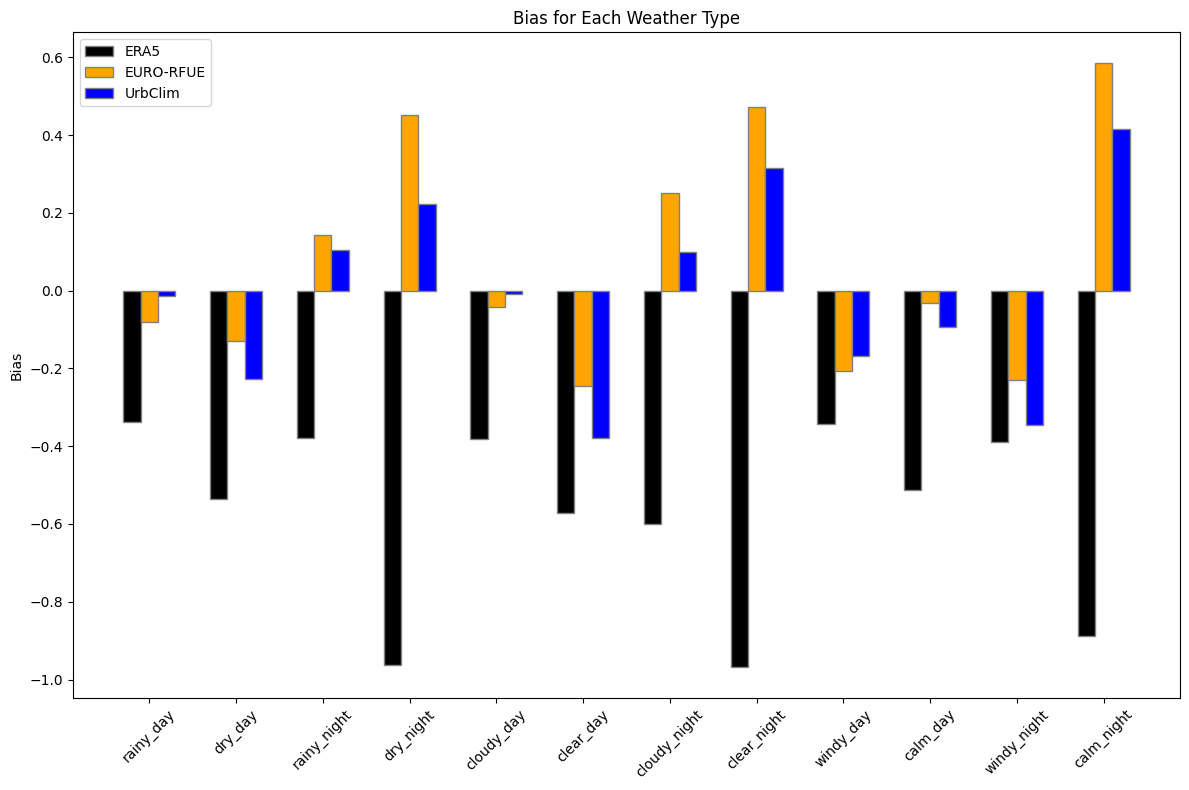

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define weather types
weather_types = ['rainy_day', 'dry_day', 'rainy_night', 'dry_night', 'cloudy_day', 'clear_day', 'cloudy_night', 'clear_night', 'windy_day', 'calm_day', 'windy_night', 'calm_night']

# Create lists to store biases for each weather type
biases = []

# Calculate biases for each weather type
for weather_type in weather_types:
    filtered_data = globals()['test_' + weather_type]

    bias_y_pred_vs_y_test = np.mean(filtered_data['y_pred'] - filtered_data['y_test'])
    bias_y_test_vs_Temperature = np.mean(filtered_data['y_test'] - filtered_data['Temperature'])
    bias_y_pred_vs_Temperature = np.mean(filtered_data['y_pred'] - filtered_data['Temperature'])
    bias_ERA5_vs_Temperature = np.mean(filtered_data['ERA5'] - filtered_data['Temperature'])

    biases.append([ bias_ERA5_vs_Temperature, bias_y_pred_vs_Temperature, bias_y_test_vs_Temperature])

# Plot biases
fig, ax = plt.subplots(figsize=(12, 8))

barWidth = 0.2
r1 = np.arange(len(weather_types))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

colors = [ 'black', 'orange', 'blue']
labels = [ 'ERA5', 'EURO-RFUE', 'UrbClim']

for i in range(3):
    ax.bar([r + barWidth*i for r in r1], [bias[i] for bias in biases], color=colors[i], width=barWidth, edgecolor='grey', label=labels[i])

#ax.set_xlabel('Weather Types', fontweight='bold')
ax.set_xticks([r + barWidth for r in range(len(weather_types))])
ax.set_xticklabels(weather_types, rotation=45)
ax.set_ylabel('Bias')
ax.set_title('Bias for Each Weather Type')
ax.legend()

plt.tight_layout()
plt.show()
